# LightGBM Tutorial

# Intro
- Light GBM 은 트리 기반 학습 알고리즘을 사용하는 Gradient Boosting Framework로
  - 빠른 학습속도와 높은 효율
  - 적은 메모리사용
  - 더 나은 정확도
  - 병렬 및 GPU 지원
  - 대규모 데이터 처리 가능

  을 이점으로 내세우고 있습니다.

- C, R, Python API를 지원하며 Python 사용법을 중점으로 설명하도록 하겠습니다.

- 예제는 titanic_4th_baseline.ipynb 자료를 기반으로 작성되었습니다.

- 본 튜토리얼은 google colab에서 작성되었고 colab을 이용한다는 가정하에 진행하겠습니다.

In [0]:
!pip install ipython-autotime
%load_ext autotime

In [0]:
from google.colab import drive
drive.mount('gdrive')

In [0]:
# 작업 디렉토리로 이동
%cd "/content/gdrive/My Drive/4th_2020/kisti_kaggle"
# 데이터셋 확인 
!ls -al ./datasets

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# seaborn scheme 설정
plt.style.use('seaborn')
# 그래프의 폰트 설정
sns.set(font_scale=2.5) 

%matplotlib inline

In [6]:
from sklearn import metrics 
from sklearn.model_selection import train_test_split

time: 1.15 ms


# 사전 준비물
- LightGBM 은 설치를 해야 이용할 수 있는 패키지로 setuptools, wheel, numpy, scipy에 의존성을 가지고 있습니다.
- 추가적으로 scikit-learn에 interface할 수 있으며 이때는 scikit-learn(sklearn)도 설치되어 있어야합니다.

- colab을 쓴다면 이미 다 설치되어있는거 같으니 아래 명령어를 실행하지 않아도 될 것 같습니다.

In [0]:
# !pip install setuptools wheel numpy scipy scikit-learn -U

- pip install을 이용하여 LightGBM을 설치해줍시다.

In [0]:
!pip install lightgbm

- import lightgbm 을 하면 이용할 수 있습니다.

In [7]:
import lightgbm as lgb

time: 1e+03 µs


# API 사용하기
- API란? Application Programming Interface의 약자로 응용 프로그램에서 사용할 수 있도록, 운영 체제나 프로그래밍 언어가 제공하는 기능을 제어할 수 있게 만든 인터페이스를 뜻합니다.
- 즉, 우리는 LightGBM을 구현할 필요 없이 이미 구현되어있는 것을 가져다 쓰면 됩니다.
- Python API로는
  1. Data Sturcture API
  2. Training API
  3. **Scikit-learn API**
  4. Callbacks
  5. Plotting
  
  가 있습니다.

- 먼저 강조되어있는 Scikit-learn API 사용법을 먼저 알아보고 나머지를 알아보도록 하겠습니다.





## scikit-learn API 사용하기
- Light GBM은 scikit-learn API를 제공하며, sklearn 사용경험을 그대로 적용하여 이용할 수 있습니다.


### 1. 데이터 로드 및 Feature Engineering

In [8]:
WORK_DIR = '.'
df_train = pd.read_csv(WORK_DIR + '/datasets/train.csv')
df_test = pd.read_csv(WORK_DIR + '/datasets/test.csv')
df_train.loc[df_train.Fare.isnull(), 'Fare'] = df_train['Fare'].mean()
df_test.loc[df_test.Fare.isnull(), 'Fare'] = df_test['Fare'].mean()

df_train['Fare'] = df_train['Fare'].map(lambda i: np.log(i) if i>0 else 0)
df_test['Fare'] = df_test['Fare'].map(lambda i: np.log(i) if i>0 else 0)
df_train['Initial']=0
for i in df_train:
    df_train['Initial']= df_train.Name.str.extract('([A-Za-z]+)\.') 
    
df_test['Initial']=0
for i in df_test:
    df_test['Initial']= df_test.Name.str.extract('([A-Za-z]+)\.')
df_train['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess',
                          'Jonkheer','Col','Rev','Capt','Sir','Don', 'Dona'],
                        ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other',
                      'Other','Other','Mr','Mr','Mr', 'Mr'],inplace=True)

df_test['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess',
                          'Jonkheer','Col','Rev','Capt','Sir','Don', 'Dona'],
                        ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other',
                        'Other','Other','Mr','Mr','Mr', 'Mr'],inplace=True)

df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Mr'),'Age']=33
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Mrs'),'Age']=37
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Master'),'Age']=5
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Miss'),'Age']=22
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Other'),'Age']=45

df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Mr'),'Age']=33
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Mrs'),'Age']=37
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Master'),'Age']=5
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Miss'),'Age']=22
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Other'),'Age']=45

df_train['Embarked'].fillna('S', inplace=True)

df_train['FamilySize'] = df_train['SibSp'] + df_train['Parch'] + 1 
df_test['FamilySize'] = df_test['SibSp'] + df_test['Parch'] + 1 


def category_age(x):
    if x < 10:
        return 0
    elif x < 20:
        return 1
    elif x < 30:
        return 2
    elif x < 40:
        return 3
    elif x < 50:
        return 4
    elif x < 60:
        return 5
    elif x < 70:
        return 6
    else:
        return 7  

df_train['Age_cat'] = df_train['Age'].apply(category_age)
df_test['Age_cat'] = df_test['Age'].apply(category_age)
df_train.drop(['Age'], axis=1, inplace=True)
df_test.drop(['Age'], axis=1, inplace=True)

df_train['Initial'] = df_train['Initial'].map(
    {'Master': 0, 'Miss': 1, 'Mr': 2, 'Mrs': 3, 'Other': 4})
df_test['Initial'] = df_test['Initial'].map(
    {'Master': 0, 'Miss': 1, 'Mr': 2, 'Mrs': 3, 'Other': 4})
df_train['Embarked'] = df_train['Embarked'].map({'C': 0, 'Q': 1, 'S': 2})
df_test['Embarked'] = df_test['Embarked'].map({'C': 0, 'Q': 1, 'S': 2})

df_train['Sex'] = df_train['Sex'].map({'female': 0, 'male': 1})
df_test['Sex'] = df_test['Sex'].map({'female': 0, 'male': 1})

df_train = pd.get_dummies(df_train, columns=['Initial'], prefix='Initial')
df_test = pd.get_dummies(df_test, columns=['Initial'], prefix='Initial')

df_train = pd.get_dummies(df_train, columns=['Embarked'], prefix='Embarked')
df_test = pd.get_dummies(df_test, columns=['Embarked'], prefix='Embarked')

df_train.drop(['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket', 'Cabin'], axis=1, inplace=True)
df_test.drop(['PassengerId', 'Name',  'SibSp', 'Parch', 'Ticket', 'Cabin'], axis=1, inplace=True)

time: 593 ms


In [9]:
df_train.head()

Survived  Pclass  Sex  ...  Embarked_0  Embarked_1  Embarked_2
0         0       3    1  ...           0           0           1
1         1       1    0  ...           1           0           0
2         1       3    0  ...           0           0           1
3         1       1    0  ...           0           0           1
4         0       3    1  ...           0           0           1

[5 rows x 14 columns]

time: 34.9 ms


### 2. 데이터 셋을 train, valid, test set으로 분리

In [0]:
X_train = df_train.drop('Survived', axis=1)
target_label = df_train['Survived']
X_test = df_test

X_tr, X_vld, y_tr, y_vld = train_test_split(X_train, target_label, test_size=0.3, random_state=2018)

### 3. 모델 생성 및 예측
- 기본적으로 회귀, 분류, 순위 모델을 제공합니다.
  - LGBMRegressor
  - LGBMClassifier
  - LGBMRanker
- 생존자를 분류해야하므로 분류모델(LGBMClassifier)을 선택하겠습니다.

In [19]:
model1 = lgb.LGBMClassifier()
model1.fit(X_tr, y_tr)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

time: 73.8 ms


In [0]:
prediction1 = model1.predict(X_vld)

In [21]:
prediction1

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1,
       0, 0, 0, 1])

time: 3.49 ms


In [22]:
# 정확도
print('총 {}명 중 {:.2f}% 정확도로 생존을 맞춤'.format(y_vld.shape[0], 100 * metrics.accuracy_score(prediction1, y_vld)))

총 268명 중 85.82% 정확도로 생존을 맞춤
time: 2.24 ms


In [23]:
print(X_tr.shape)
print(X_vld.shape)

(623, 13)
(268, 13)
time: 996 µs


In [24]:
(prediction1 == y_vld).sum()/prediction1.shape[0]

0.8582089552238806

time: 3.9 ms


Light GBM은 자체적으로 plot_importance를 제공합니다.

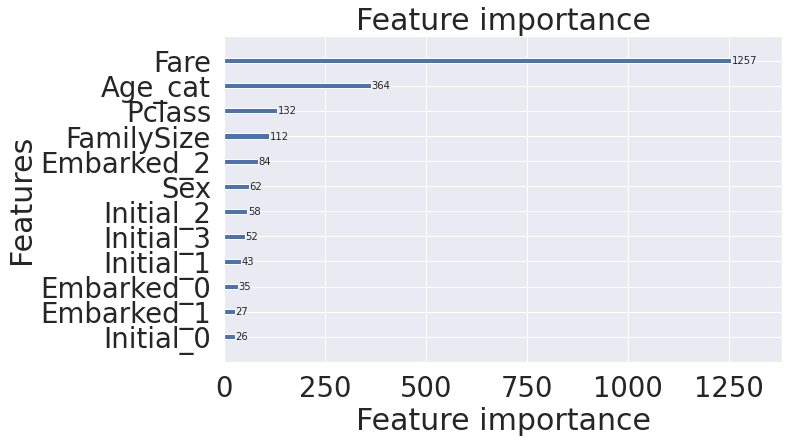

time: 376 ms


In [34]:
fig, ax = plt.subplots(figsize=(10,6))
lgb.plot_importance(model1, ax = ax)

## Python API 사용하기
- kaggle 수업에서 LightGBM에 카테고리를 처리하는 내장 알고리즘이 있다고 배웠습니다. 그것을 활용하여 Feature Engineering을 해보도록 하겠습니다.

### 1. Data Structure API
- LightGBM 자체의 Dataset이 존재합니다.
- 수 많은 parameter가 존재하지만 여기에선 data, label, reference, categorical_feature, free_raw_data 만 다루도록 하겠습니다.
    - data : Dataset에 들어갈 data입니다. numpy array, pandas Dataframe 등을 받습니다.
    - label : 데이터 레이블(정답)입니다. numpy 1-D array, pandas Series or one-column Dataframe 등을 받습니다.
    - reference : validation 데이터셋일경우 train dataset을 입력해줍니다.
    - categorical_feature : list를 받습니다. int 리스트일 경우 indices로 해석되고 str 리스트일 경우 feature names로 인식됩니다.
    - free_raw_data : True 일경우, Dataset을 형성 후 raw data를 지우니 False로 설정해줍시다.

기존의 Feature Engineering에서 one-hot encoding 부분을 제외하고 가져와줍니다.

In [0]:
WORK_DIR = '.'
df_train = pd.read_csv(WORK_DIR + '/datasets/train.csv')
df_test = pd.read_csv(WORK_DIR + '/datasets/test.csv')
df_train.loc[df_train.Fare.isnull(), 'Fare'] = df_train['Fare'].mean()
df_test.loc[df_test.Fare.isnull(), 'Fare'] = df_test['Fare'].mean()

df_train['Fare'] = df_train['Fare'].map(lambda i: np.log(i) if i>0 else 0)
df_test['Fare'] = df_test['Fare'].map(lambda i: np.log(i) if i>0 else 0)
df_train['Initial']=0
for i in df_train:
    df_train['Initial']= df_train.Name.str.extract('([A-Za-z]+)\.') 
    
df_test['Initial']=0
for i in df_test:
    df_test['Initial']= df_test.Name.str.extract('([A-Za-z]+)\.')
df_train['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess',
                          'Jonkheer','Col','Rev','Capt','Sir','Don', 'Dona'],
                        ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other',
                      'Other','Other','Mr','Mr','Mr', 'Mr'],inplace=True)

df_test['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess',
                          'Jonkheer','Col','Rev','Capt','Sir','Don', 'Dona'],
                        ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other',
                        'Other','Other','Mr','Mr','Mr', 'Mr'],inplace=True)

df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Mr'),'Age']=33
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Mrs'),'Age']=37
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Master'),'Age']=5
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Miss'),'Age']=22
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Other'),'Age']=45

df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Mr'),'Age']=33
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Mrs'),'Age']=37
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Master'),'Age']=5
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Miss'),'Age']=22
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Other'),'Age']=45

df_train['Embarked'].fillna('S', inplace=True)

df_train['FamilySize'] = df_train['SibSp'] + df_train['Parch'] + 1 
df_test['FamilySize'] = df_test['SibSp'] + df_test['Parch'] + 1 


def category_age(x):
    if x < 10:
        return 0
    elif x < 20:
        return 1
    elif x < 30:
        return 2
    elif x < 40:
        return 3
    elif x < 50:
        return 4
    elif x < 60:
        return 5
    elif x < 70:
        return 6
    else:
        return 7  

df_train['Age_cat'] = df_train['Age'].apply(category_age)
df_test['Age_cat'] = df_test['Age'].apply(category_age)
df_train.drop(['Age'], axis=1, inplace=True)
df_test.drop(['Age'], axis=1, inplace=True)

df_train['Initial'] = df_train['Initial'].map(
    {'Master': 0, 'Miss': 1, 'Mr': 2, 'Mrs': 3, 'Other': 4})
df_test['Initial'] = df_test['Initial'].map(
    {'Master': 0, 'Miss': 1, 'Mr': 2, 'Mrs': 3, 'Other': 4})
df_train['Embarked'] = df_train['Embarked'].map({'C': 0, 'Q': 1, 'S': 2})
df_test['Embarked'] = df_test['Embarked'].map({'C': 0, 'Q': 1, 'S': 2})

df_train['Sex'] = df_train['Sex'].map({'female': 0, 'male': 1})
df_test['Sex'] = df_test['Sex'].map({'female': 0, 'male': 1})

# df_train = pd.get_dummies(df_train, columns=['Initial'], prefix='Initial')
# df_test = pd.get_dummies(df_test, columns=['Initial'], prefix='Initial')

# df_train = pd.get_dummies(df_train, columns=['Embarked'], prefix='Embarked')
# df_test = pd.get_dummies(df_test, columns=['Embarked'], prefix='Embarked')

df_train.drop(['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket', 'Cabin'], axis=1, inplace=True)
df_test.drop(['PassengerId', 'Name',  'SibSp', 'Parch', 'Ticket', 'Cabin'], axis=1, inplace=True)

### 2. 데이터 셋을 train, valid, test set으로 분리 및 categorical_feature 설정
- 앞서 했던 것과 같이 train, valid, test set으로 분리해준 뒤 lgb.Dataset을 이용해서 LGBM에 이용할 데이터셋을 만들어 줍니다.

In [0]:
X_train = df_train.drop('Survived', axis=1)
target_label = df_train['Survived']
X_test = df_test
X_tr, X_vld, y_tr, y_vld = train_test_split(X_train, target_label, test_size=0.3, random_state=2018)

lgb_train = lgb.Dataset(X_tr, label=y_tr, categorical_feature=["Embarked","Initial"], free_raw_data=False)
lgb_vld = lgb.Dataset(X_vld, label=y_vld, reference=lgb_train, categorical_feature=["Embarked","Initial"], free_raw_data=False)
lgb_test = lgb.Dataset(X_test, categorical_feature=["Embarked","Initial"], free_raw_data=False)

### 3. Training API
- sklearn API에서는 모델을 생성하고 fit으로 학습을 시켰는데요.
- Training API를 이용하면 학습과 동시에 학습된 모델을 얻을 수 있습니다.
- 인자는 수없이 많지만 역시 간단하게 parameters, train_set, valid_sets, categorical_feature 만 다루겠습니다.
  - parameters : 학습을 세팅하기위한 parameter들 입니다. dictionary 자료형을 받습니다.
  - train_set : 학습할 데이터입니다. LGBM Dataset을 받습니다.
  - valid_sets : validation 데이터입니다. LGBM Dataset을 받습니다.
  - categorical_feature : list를 받습니다. int 리스트일 경우 indices로 해석되고 str 리스트일 경우 feature names로 인식됩니다.

- parameters에 들어갈 parameter들도 많지만 최소화 하였습니다.
  - objective : 어떤 모델을 설정할지 정합니다. 죽었느냐(0), 살았느냐(1)를 판단하는 이진분류 모델이기 때문에 binary를 선택했습니다.


In [37]:
parameters = {
    'objective' : 'binary'
}
model2 = lgb.train(parameters,
                       lgb_train,
                       valid_sets=lgb_vld,
                       categorical_feature=["Embarked","Initial"])

[1]	valid_0's binary_logloss: 0.611192
[2]	valid_0's binary_logloss: 0.575233
[3]	valid_0's binary_logloss: 0.546722
[4]	valid_0's binary_logloss: 0.522915
[5]	valid_0's binary_logloss: 0.503094
[6]	valid_0's binary_logloss: 0.486475
[7]	valid_0's binary_logloss: 0.472224
[8]	valid_0's binary_logloss: 0.459766
[9]	valid_0's binary_logloss: 0.447312
[10]	valid_0's binary_logloss: 0.436493
[11]	valid_0's binary_logloss: 0.427872
[12]	valid_0's binary_logloss: 0.420444
[13]	valid_0's binary_logloss: 0.413497
[14]	valid_0's binary_logloss: 0.408128
[15]	valid_0's binary_logloss: 0.402446
[16]	valid_0's binary_logloss: 0.398162
[17]	valid_0's binary_logloss: 0.394887
[18]	valid_0's binary_logloss: 0.392171
[19]	valid_0's binary_logloss: 0.390384
[20]	valid_0's binary_logloss: 0.387609
[21]	valid_0's binary_logloss: 0.384082
[22]	valid_0's binary_logloss: 0.382414
[23]	valid_0's binary_logloss: 0.381917
[24]	valid_0's binary_logloss: 0.38089
[25]	valid_0's binary_logloss: 0.380287
[26]	valid

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


결과가 실수 형태로 나와서 반올림을 하고 정수형으로 바꿔주는 작업을 했습니다.

In [0]:
prediction2 = np.round(model2.predict(X_vld)).astype(np.int)

In [39]:
prediction2

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1,
       0, 0, 0, 1])

time: 3.57 ms


In [40]:
print('총 {}명 중 {:.2f}% 정확도로 생존을 맞춤'.format(y_vld.shape[0], 100 * metrics.accuracy_score(prediction2, y_vld)))

총 268명 중 84.33% 정확도로 생존을 맞춤
time: 2.12 ms


In [41]:
fig, ax = plt.subplots(figsize=(10,6))
lgb.plot_importance(model2, ax = ax)

time: 330 ms


## Reference
1. https://lightgbm.readthedocs.io/
2. https://github.com/microsoft/LightGBM/blob/master/examples/python-guide/simple_example.py
3. https://www.kaggle.com/shep312/applying-lightgbm-to-titanic-dataset